In [115]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import warnings
warnings.filterwarnings('ignore')

pd.pandas.set_option('display.max_columns', None)

# Load The Datasets

In [116]:
df_train = pd.read_csv('./data/train.csv', index_col='id')
df_test = pd.read_csv('./data/test.csv', index_col='id')
df_sample_submission = pd.read_csv('./data/sample_submission.csv')

print("train data shape is {}" .format(df_train.shape))
print("test data shape is {}" .format(df_test.shape))
print("sample_submission data shape is {}" .format(df_sample_submission.shape))

train data shape is (517754, 13)
test data shape is (172585, 12)
sample_submission data shape is (172585, 2)


In [117]:
df_train.head(10)

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
id,,,,,,,,,,,,,
0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56
5,highway,3,0.54,70,night,foggy,True,False,morning,False,True,0,0.61
6,highway,1,0.04,45,night,foggy,False,True,morning,True,False,2,0.20
7,highway,2,0.33,45,daylight,clear,False,True,evening,False,True,0,0.16
8,rural,3,0.63,25,dim,clear,True,False,evening,True,True,2,0.18


In [118]:
df_train.dtypes

road_type                  object
num_lanes                   int64
curvature                 float64
speed_limit                 int64
lighting                   object
weather                    object
road_signs_present           bool
public_road                  bool
time_of_day                object
holiday                      bool
school_season                bool
num_reported_accidents      int64
accident_risk             float64
dtype: object

In [119]:
df_train.dtypes[df_train.dtypes!='object']

num_lanes                   int64
curvature                 float64
speed_limit                 int64
road_signs_present           bool
public_road                  bool
holiday                      bool
school_season                bool
num_reported_accidents      int64
accident_risk             float64
dtype: object

In [120]:
df_train.dtypes[df_train.dtypes=='object']

road_type      object
lighting       object
weather        object
time_of_day    object
dtype: object

In [121]:
print("Missing Values Count for Train Dataset")

df_train.isnull().sum()

Missing Values Count for Train Dataset


road_type                 0
num_lanes                 0
curvature                 0
speed_limit               0
lighting                  0
weather                   0
road_signs_present        0
public_road               0
time_of_day               0
holiday                   0
school_season             0
num_reported_accidents    0
accident_risk             0
dtype: int64

In [122]:
print("Missing Values Count for Test Dataset")

df_test.isnull().sum()

Missing Values Count for Test Dataset


road_type                 0
num_lanes                 0
curvature                 0
speed_limit               0
lighting                  0
weather                   0
road_signs_present        0
public_road               0
time_of_day               0
holiday                   0
school_season             0
num_reported_accidents    0
dtype: int64

# Data Visualization

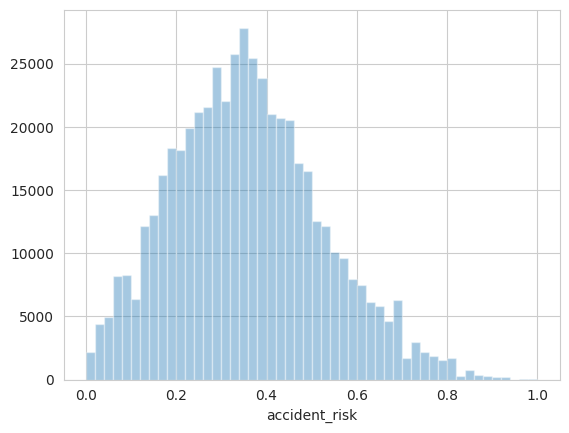

In [123]:
# Distribution of values in target feature
sns.distplot(df_train.get('accident_risk'), kde=False)
plt.show()

Distribution of Numeric Features (Train vs Test)


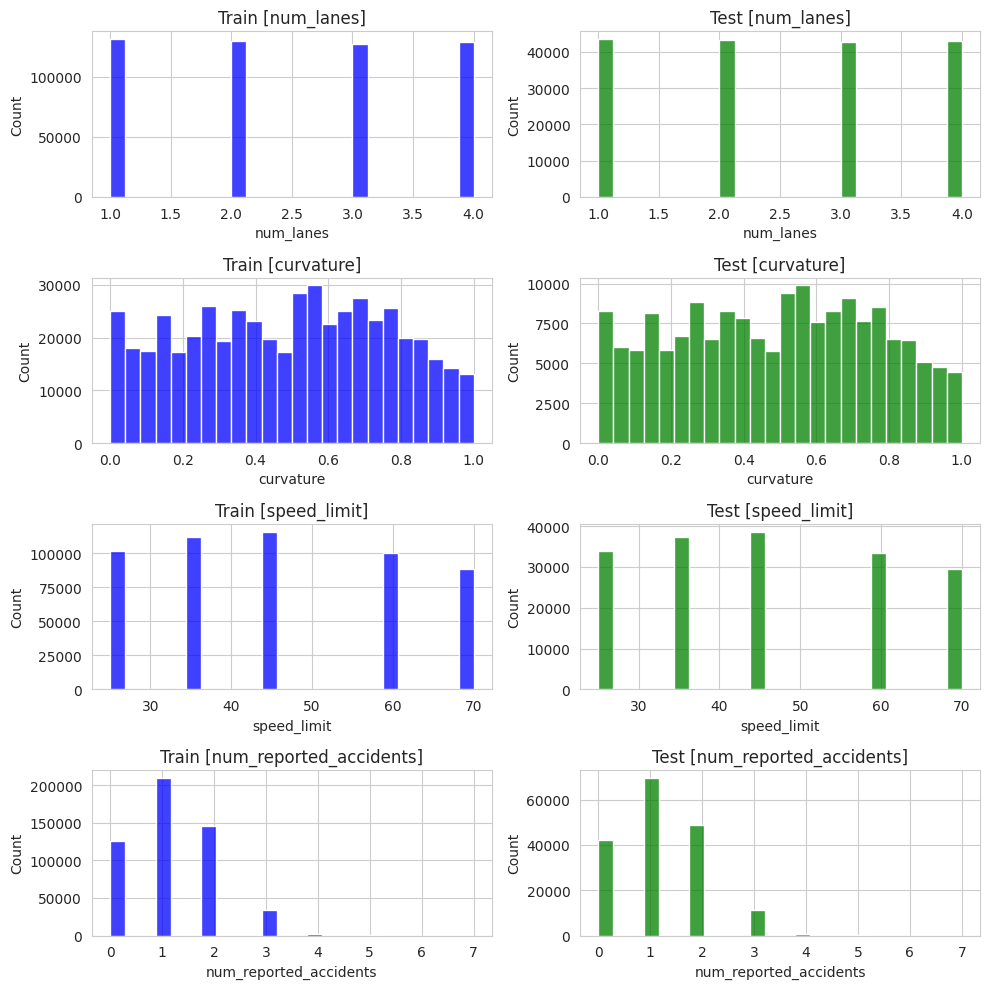

In [124]:
print("Distribution of Numeric Features (Train vs Test)")

num_cols = df_test.select_dtypes(include=['number']).columns

plt.figure(figsize=(10, len(num_cols) * 2.5))

for i, col in enumerate(num_cols):
    plt.subplot(len(num_cols), 2, i*2 + 1)
    sns.histplot(df_train[col], bins=24, color='blue')
    plt.title(f"Train [{col}]")
    plt.xlabel(col)
    
    plt.subplot(len(num_cols), 2, i*2 + 2)
    sns.histplot(df_test[col], bins=24, color='green')
    plt.title(f"Test [{col}]")
    plt.xlabel(col)
    
plt.tight_layout()
plt.show()

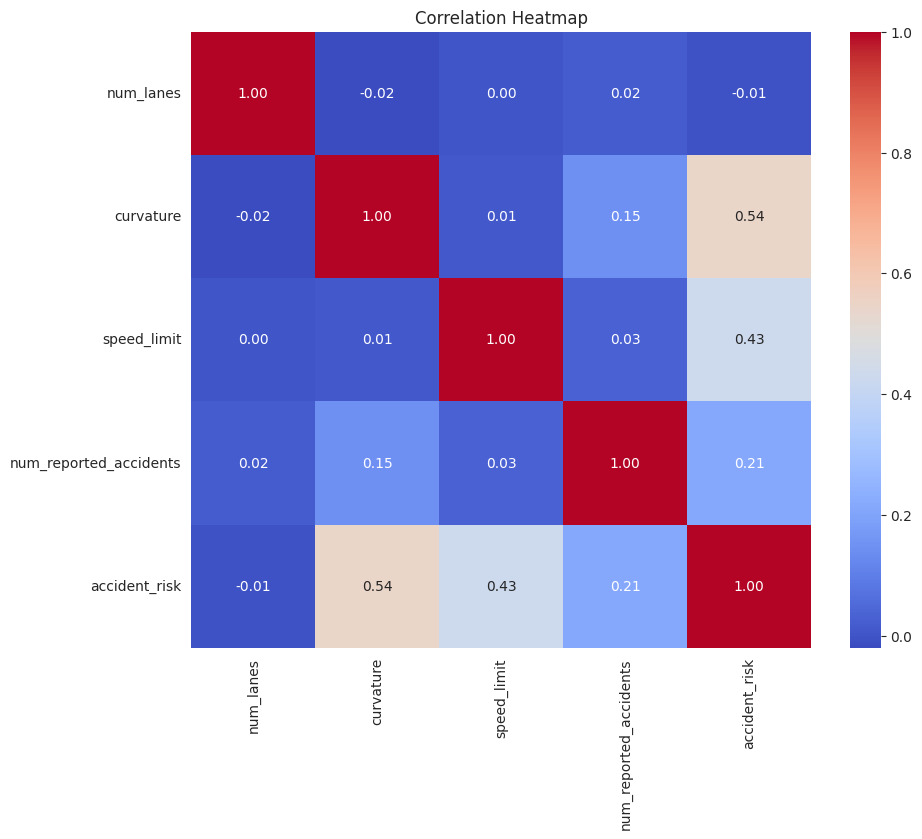


--- Correlation with Target ---
accident_risk             1.000000
curvature                 0.543946
speed_limit               0.430898
num_reported_accidents    0.213891
num_lanes                -0.006003
Name: accident_risk, dtype: float64


In [125]:
# Correlation Analysis
numeric_cols = df_train.select_dtypes(include='number').columns

plt.figure(figsize=(10,8))
sns.heatmap(df_train[numeric_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Correlation with target
print("\n--- Correlation with Target ---")
print(df_train[numeric_cols].corr()['accident_risk'].sort_values(ascending=False))

Donut Chart Comparison of Categorical Variables in Train, Test Datasets


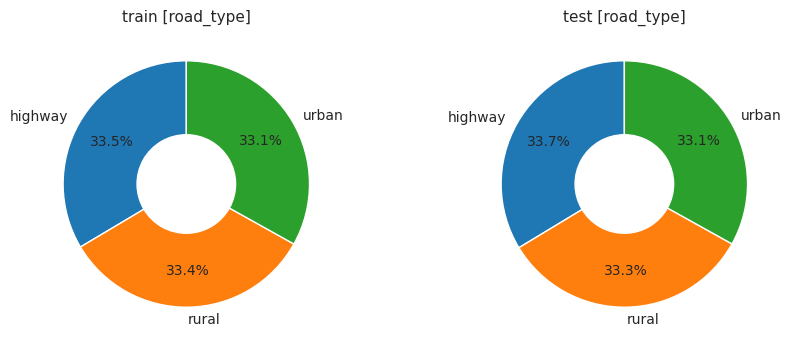

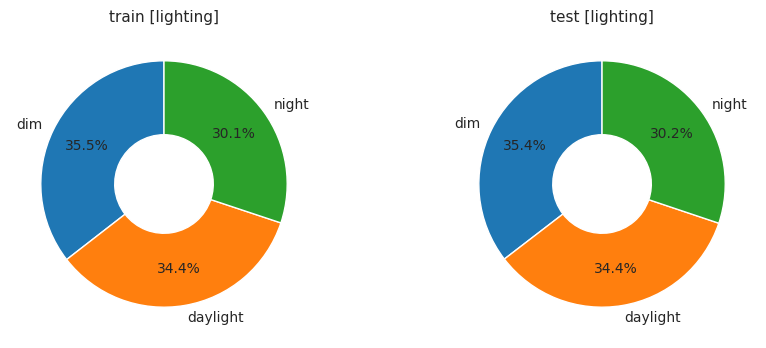

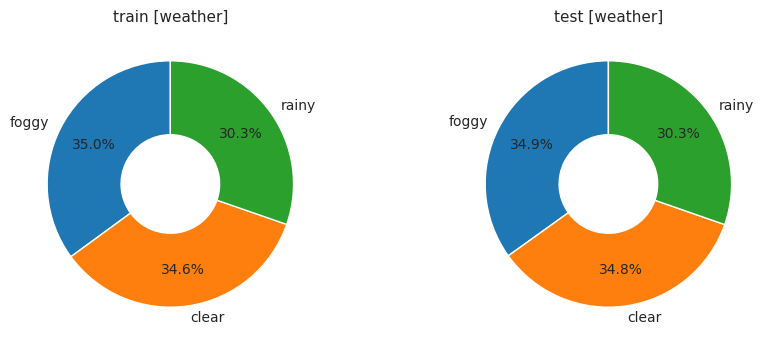

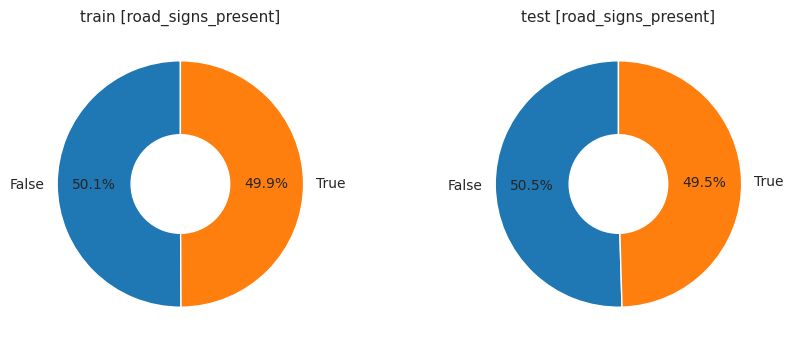

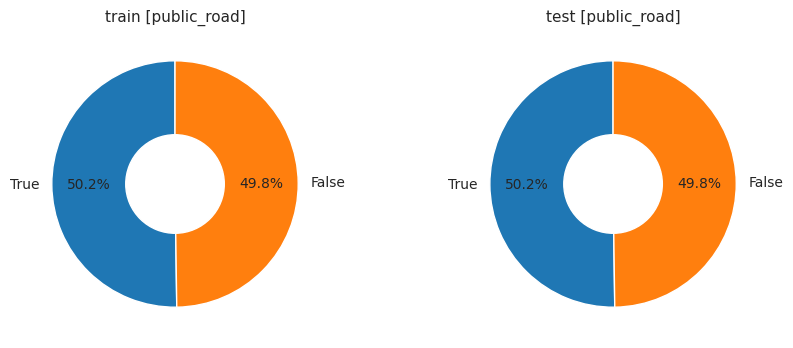

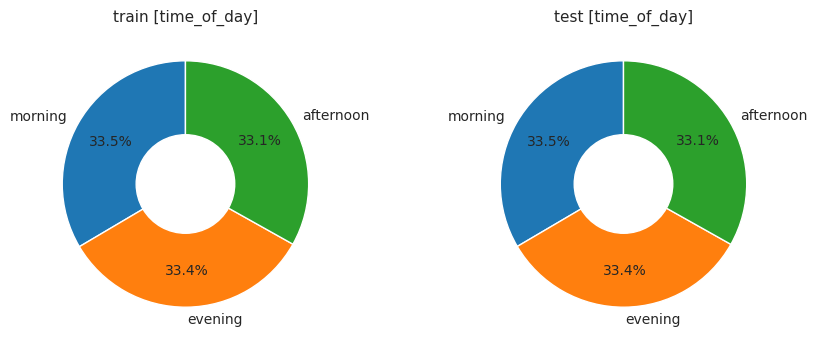

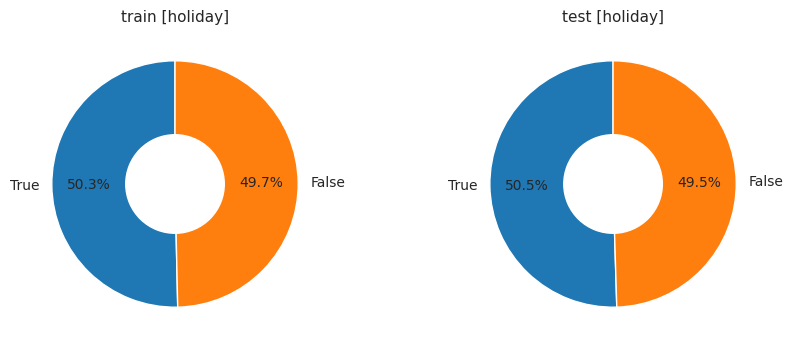

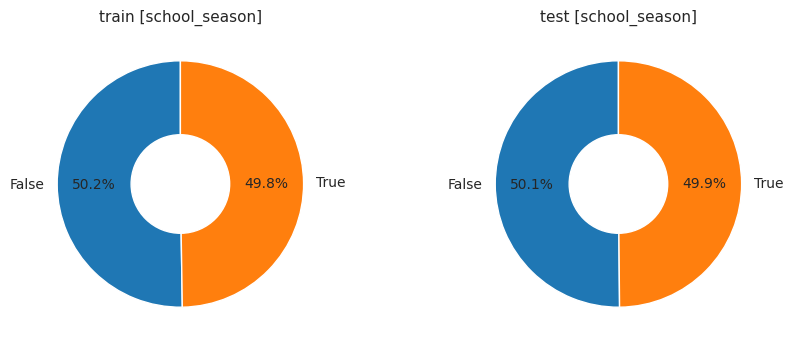

In [126]:
print("Donut Chart Comparison of Categorical Variables in Train, Test Datasets")

# Get the columns with object data type
obj_cols = df_train.select_dtypes(include=['object', 'bool']).columns

for variable in obj_cols:
    sns.set_style('whitegrid')
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    plt.subplots_adjust(wspace=0.3)
    
    # Donut Chart for Train data
    df_train[variable].value_counts().plot.pie(ax=axes[0], autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.6), pctdistance=0.7)
    axes[0].set_ylabel('')
    axes[0].set_title(f"train [{variable}]", fontsize=11)
    
    # Donut Chart for Test data
    df_test[variable].value_counts().plot.pie(ax=axes[1], autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.6), pctdistance=0.7)
    axes[1].set_ylabel('')
    axes[1].set_title(f"test [{variable}]", fontsize=11)
        
    plt.show()

# Feature Engineering

In [128]:
ohe_cols = ['road_type', 'lighting', 'weather', 'time_of_day']
bool_cols = ['road_signs_present', 'public_road', 'holiday', 'school_season']
n_cols = ['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents']

In [129]:
num_pipeline = Pipeline(steps=[
    ("impute", SimpleImputer(strategy='mean')),
    ("scaler", StandardScaler())
])

In [130]:
ohe_pipeline = Pipeline(steps=[
    ("impute", SimpleImputer(strategy='most_frequent')),
    ("ohe", OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [131]:
col_trans = ColumnTransformer(transformers=[
    ('num_p', num_pipeline, n_cols),
    ('bool', 'passthrough', bool_cols),
    ('ohe_p', ohe_pipeline, ohe_cols)
], remainder='passthrough', n_jobs=-1)

In [132]:
pipeline = Pipeline(steps=[
    ('preprocessing', col_trans)
])

In [133]:
X = df_train.drop(columns=['accident_risk'], axis=1)
y = df_train['accident_risk']

In [134]:
X_preprocessed = pipeline.fit_transform(X)

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, random_state=42, test_size=0.2)

# Build Models

In [136]:
XGB = XGBRegressor(random_state=42)

In [137]:
param_dist = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 2, 3],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

In [ ]:
# Fit XGBoost with GridSearchCV
xgb_cv = RandomizedSearchCV(
    XGB,
    param_distributions=param_dist,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1,
    random_state=42
)

In [139]:
xgb_cv.fit(X_train, y_train)

,estimator,"XGBRegressor(...ree=None, ...)"
,param_distributions,"{'colsample_bytree': [0.8, 0.9, ...], 'gamma': [0, 0.1, ...], 'learning_rate': [0.05, 0.1, ...], 'max_depth': [3, 5, ...], ...}"
,n_iter,20
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [140]:
# Evaluate RMSE on validation
np.sqrt(-1 * xgb_cv.best_score_)

np.float64(0.05601265710867315)

In [141]:
# Predict directly with best XGB model
y_pred_xgb = xgb_cv.best_estimator_.predict(X_test)

In [142]:
# Calculate RMSE on test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print("Test RMSE:", rmse_test)

Test RMSE: 0.05617518825740185


In [143]:
# Transform test dataset
df_test_preprocess = pipeline.transform(df_test)

In [144]:
# Predict for submission
y_submission = xgb_cv.best_estimator_.predict(df_test_preprocess)

In [145]:
# Display the sample submission DataFrame
display(df_sample_submission)

,id,accident_risk
0,517754,0.352
1,517755,0.352
2,517756,0.352
3,517757,0.352
4,517758,0.352
...,...,...
172580,690334,0.352
172581,690335,0.352
172582,690336,0.352
172583,690337,0.352


In [146]:
# Insert predicted values into the 'accident_risk' column
df_sample_submission['accident_risk'] = y_submission

# Save the completed submission file as CSV
df_sample_submission.to_csv('submission.csv', index=False)

# Display the submission DataFrame
display(df_sample_submission)

,id,accident_risk
0,517754,0.293495
1,517755,0.122449
2,517756,0.181398
3,517757,0.317844
4,517758,0.407138
...,...,...
172580,690334,0.105266
172581,690335,0.516584
172582,690336,0.251901
172583,690337,0.127664
